## Importing the dataset and primary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
kickstart=pd.read_csv("ks-projects-201801.csv")

### Checking for missing data

In [2]:
kickstart.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

### Investigating the issue with the usd pledged column

In [3]:
kickstart[kickstart['usd pledged'].isna()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",NaN,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",NaN,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,"N,0""",NaN,1585.00,1200.00


### usd pledged is merely a conversion made by kickstarter, while usd_pledged_real was made by an external currency converter (and has no missing data). So the missing data is not an issue in this case; we just have to use the usd_pledged_real column.

In [4]:
kickstart.drop(columns=['usd pledged','pledged']);

### Now we convert the launched and deadline columns into datetime objects to manipulate and analyze them easier. We also add a new column, campLength, which is the length of the campaign, then extract the day attribute from this new column to create the days column.

### Removing the campaigns that last longer than 365 days helps deal with the few campaigns that have 1/1/1970 set as their launch date.

In [5]:
kickstart['launched']=pd.to_datetime(kickstart['launched'])
kickstart['deadline']=pd.to_datetime(kickstart['deadline'])
kickstart['camp_length']=kickstart['deadline']-kickstart['launched']
kickstart['days']=kickstart['camp_length'].dt.days
kickstart=kickstart[kickstart['days']<365]

In [6]:
kickstart['launch_month']=kickstart.launched.dt.month
kickstart['launch_year']=kickstart.launched.dt.year
kickstart['ratio']=kickstart['usd_pledged_real']/kickstart['usd_goal_real']
kickstart['pledge_ratio']=kickstart['usd_pledged_real']/kickstart['backers']

In [7]:
kickstart.pledge_ratio=kickstart.pledge_ratio.fillna(0.0)
kickstart.pledge_ratio=kickstart.pledge_ratio.replace([np.inf, -np.inf], 0.0)

In [9]:
# Prepare data for bar chart of annual campaign count
kickstart=kickstart.sort_values(['launched'])
success=kickstart[(kickstart['state']=="successful")&(kickstart['ratio']>=1)]
failure=kickstart[(kickstart['state']=="failed")&(kickstart['ratio']<1)]

annual=pd.DataFrame(kickstart.launch_year.value_counts())
annualSorted=pd.DataFrame(annual.sort_index())
annualSuccess=pd.DataFrame(success.launch_year.value_counts())
annualSuccessSorted=pd.DataFrame(annualSuccess.sort_index())
annualFailure=pd.DataFrame(failure.launch_year.value_counts())
annualFailureSorted=pd.DataFrame(annualFailure.sort_index())

monthly=pd.DataFrame(kickstart.launch_month.value_counts())
monthlySorted=pd.DataFrame(monthly.sort_index())
monthlySuccess=pd.DataFrame(success.launch_month.value_counts())
monthlySuccessSorted=pd.DataFrame(monthlySuccess.sort_index())
monthlyFailure=pd.DataFrame(failure.launch_month.value_counts())
monthlyFailureSorted=pd.DataFrame(monthlyFailure.sort_index())

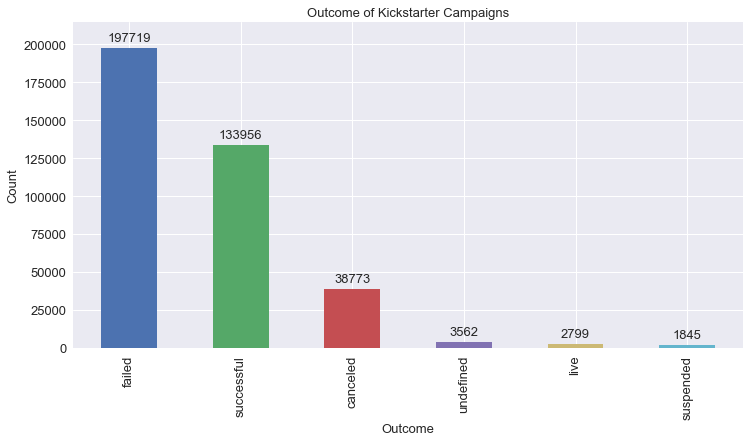

In [10]:
ax=kickstart['state'].value_counts().plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Outcome of Kickstarter Campaigns",fontsize=13)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Outcome",fontsize=13)
ax.set_ylim(0,215000)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=13)
plt.show()

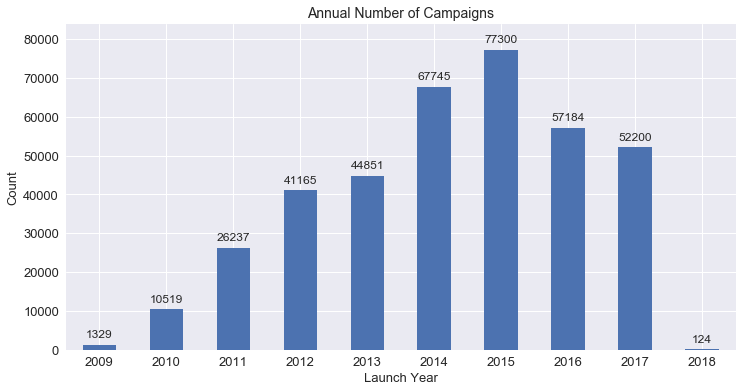

In [11]:
ax=annualSorted.plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Annual Number of Campaigns",fontsize=14)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Launch Year",fontsize=13)
ax.set_ylim(0,84000)
ax.tick_params(rotation=0)

# Add numbers above bars
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

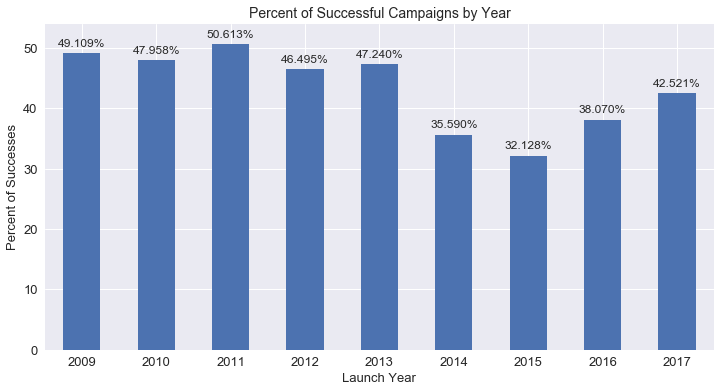

In [12]:
ax=((annualSuccessSorted)/(annualSuccessSorted+annualFailureSorted)*100).plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Percent of Successful Campaigns by Year",fontsize=14)
ax.set_ylabel("Percent of Successes",fontsize=13)
ax.set_xlabel("Launch Year",fontsize=13)
ax.set_ylim(0,54)
ax.tick_params(rotation=0)

# Add numbers above bars
for p in ax.patches:
    ax.annotate(str("%.3f"% p.get_height()+"%"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

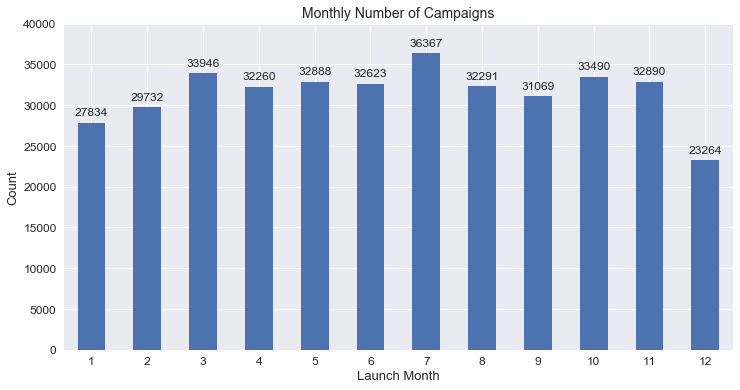

In [13]:
ax=monthlySorted.plot(kind='bar',fontsize=12,figsize=(12,6))
ax.set_title("Monthly Number of Campaigns",fontsize=14)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Launch Month",fontsize=13)
ax.tick_params(rotation=0)
ax.set_ylim(0,40000)

# Add numbers above bars
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

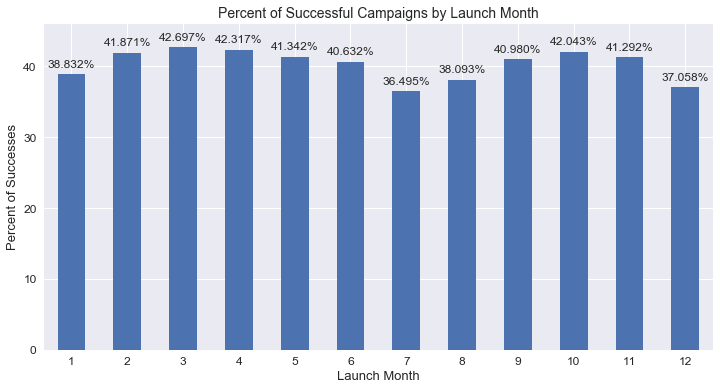

In [14]:
ax=((monthlySuccessSorted)/(monthlySuccessSorted+monthlyFailureSorted)*100).plot(kind='bar',fontsize=12,figsize=(12,6))
ax.set_title("Percent of Successful Campaigns by Launch Month",fontsize=14)
ax.set_ylabel("Percent of Successes",fontsize=13)
ax.set_xlabel("Launch Month",fontsize=13)
ax.tick_params(rotation=0)
ax.set_ylim(0,46)

# Add numbers above bars
for p in ax.patches:
    ax.annotate(str("%.3f"% p.get_height()+"%"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

### Since the outcome of a kickstarter campaign is categorical, we can one hot encode the outcome column.

In [15]:
one_hot_state=pd.get_dummies(kickstart['state'])
kickstart=kickstart.join(one_hot_state)

### The main_category and currency columns may be used to assist in predictions as well.

In [16]:
one_hot_maincat=pd.get_dummies(kickstart['main_category'])
kickstart=kickstart.join(one_hot_maincat)

In [17]:
one_hot_currency=pd.get_dummies(kickstart['currency'])
kickstart=kickstart.join(one_hot_currency)

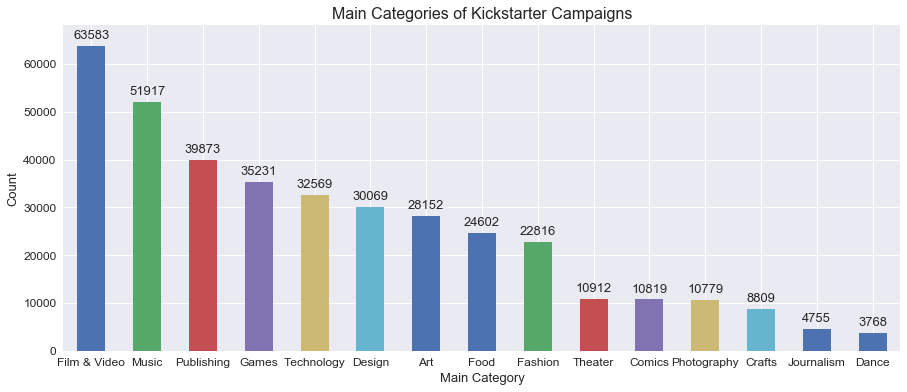

In [18]:
ax=kickstart['main_category'].value_counts().plot(kind='bar',fontsize=12,figsize=(15,6))
ax.set_title("Main Categories of Kickstarter Campaigns",fontsize=16)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Main Category",fontsize=13)
ax.set_ylim(0,68000)
ax.tick_params(rotation=0)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=13)
plt.show()

In [58]:
cats=["Film & Video", "Music", "Publishing","Games","Technology","Design","Art","Food","Fashion","Theater","Comics","Photography","Crafts","Journalism","Dance"]
success_rates=[]
filmAndVideo=kickstart[kickstart.main_category=="Film & Video"]
success_rates.append((filmAndVideo.state=="successful").sum()/len(filmAndVideo))

Music=kickstart[kickstart.main_category=="Music"]
success_rates.append((Music.state=="successful").sum()/len(Music))

Publishing=kickstart[kickstart.main_category=="Publishing"]
success_rates.append((Publishing.state=="successful").sum()/len(Publishing))

Games=kickstart[kickstart.main_category=="Games"]
success_rates.append((Games.state=="successful").sum()/len(Games))


Tech=kickstart[kickstart.main_category=="Technology"]
success_rates.append((Tech.state=="successful").sum()/len(Tech))


Design=kickstart[kickstart.main_category=="Design"]
success_rates.append((Design.state=="successful").sum()/len(Design))


Art=kickstart[kickstart.main_category=="Art"]
success_rates.append((Art.state=="successful").sum()/len(Art))

Food=kickstart[kickstart.main_category=="Food"]
success_rates.append((Art.state=="successful").sum()/len(Food))

Fashion=kickstart[kickstart.main_category=="Fashion"]
success_rates.append((Fashion.state=="successful").sum()/len(Fashion))

Theater=kickstart[kickstart.main_category=="Theater"]
success_rates.append((Theater.state=="successful").sum()/len(Theater))

Comics=kickstart[kickstart.main_category=="Comics"]
success_rates.append((Comics.state=="successful").sum()/len(Comics))

Photography=kickstart[kickstart.main_category=="Photography"]
success_rates.append((Photography.state=="successful").sum()/len(Photography))

Crafts=kickstart[kickstart.main_category=="Crafts"]
success_rates.append((Crafts.state=="successful").sum()/len(Crafts))

Journalism=kickstart[kickstart.main_category=="Journalism"]
success_rates.append((Journalism.state=="successful").sum()/len(Journalism))

Dance=kickstart[kickstart.main_category=="Dance"]
success_rates.append((Dance.state=="successful").sum()/len(Dance))
success_rates.sort()

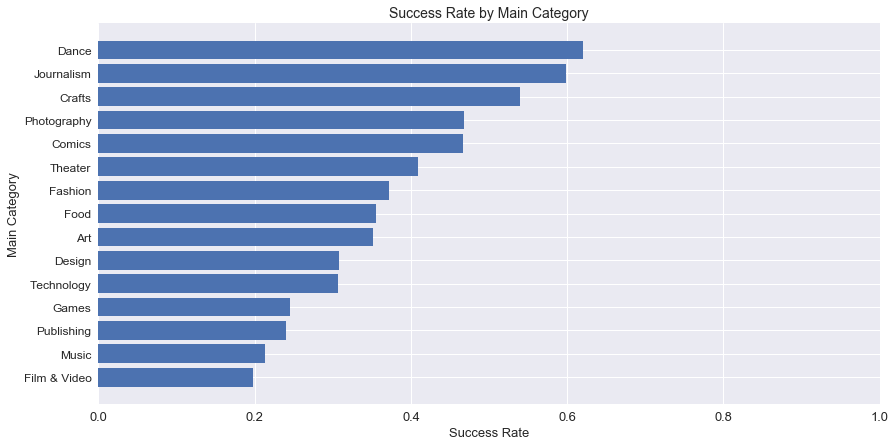

In [61]:
plt.figure(figsize=(14,7))
plt.barh(cats,success_rates)
plt.xlim(0,1)
plt.title("Success Rate by Main Category",fontsize=14)
plt.xlabel("Success Rate",fontsize=13)
plt.ylabel("Main Category",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.show()

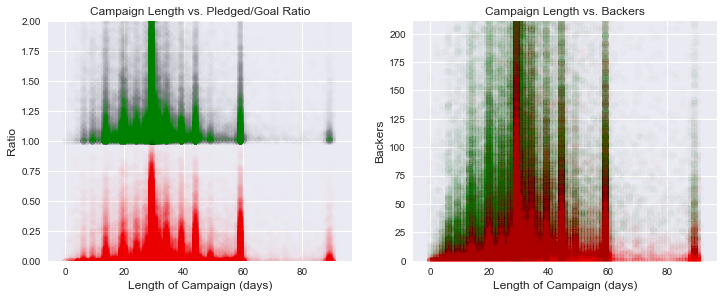

In [78]:
plt.figure(figsize=(12,15))

ax1=plt.subplot(321)
ax1.scatter(success['days'],success['ratio'],c='green',alpha=0.005)
ax1.scatter(failure['days'],failure['ratio'],c='red',alpha=0.005)
plt.ylim(0,2)
plt.title("Campaign Length vs. Pledged/Goal Ratio",fontsize=12)
plt.xlabel("Length of Campaign (days)",fontsize=12)
plt.ylabel("Ratio",fontsize=12)

ax2=plt.subplot(322)
ax2.scatter(success['days'],success['backers'],c='green',alpha=0.01)
ax2.scatter(failure['days'],failure['backers'],c='red',alpha=0.01)
plt.ylim(0,np.mean(kickstart.backers)*2)
plt.title("Campaign Length vs. Backers",fontsize=12)
plt.xlabel("Length of Campaign (days)",fontsize=12)
plt.ylabel("Backers",fontsize=12)


plt.show()

### Campaigns that last 30 days have the highest density for their pledged to goal ratio and the number of backers


# Random Forest Classification - Predicting Success
### Figuring out the most important features

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_cols=['usd_goal_real', 'days', 'launch_month', 'launch_year', 'Art', 'Comics',
       'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
       'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
       'Theater', 'AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP',
       'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']
X = kickstart[X_cols]
y = kickstart['successful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.432197 	usd_goal_real
2. feature 1 	0.212285 	days
3. feature 2 	0.178627 	launch_month
4. feature 3 	0.082311 	launch_year
5. feature 14 	0.007974 	Art
6. feature 18 	0.007445 	Comics
7. feature 17 	0.007034 	Crafts
8. feature 5 	0.005882 	Dance
9. feature 32 	0.005481 	Design
10. feature 9 	0.005079 	Fashion
11. feature 16 	0.004979 	Film & Video
12. feature 10 	0.004469 	Food
13. feature 12 	0.004455 	Games
14. feature 24 	0.004160 	Journalism
15. feature 8 	0.004064 	Music
16. feature 11 	0.003692 	Photography
17. feature 4 	0.003614 	Publishing
18. feature 7 	0.003430 	Technology
19. feature 23 	0.003044 	Theater
20. feature 6 	0.002932 	AUD
21. feature 15 	0.002914 	CAD
22. feature 20 	0.002909 	CHF
23. feature 19 	0.002303 	DKK
24. feature 13 	0.002136 	EUR
25. feature 30 	0.001209 	GBP
26. feature 29 	0.001087 	HKD
27. feature 27 	0.000928 	JPY
28. feature 22 	0.000903 	MXN
29. feature 21 	0.000654 	NOK
30. feature 28 	0.000639 	NZD
31. feature 

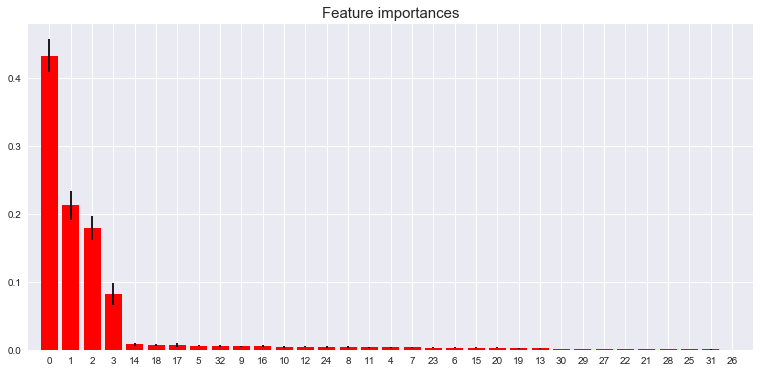

In [80]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [81]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.78      0.71      0.74     53595
          1       0.42      0.52      0.47     22136

avg / total       0.68      0.65      0.66     75731



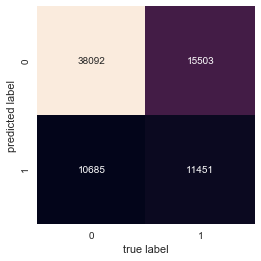

In [82]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Predictors - goal, days, launch month, launch year

In [83]:
X_cols=['usd_goal_real', 'days', 'launch_month', 'launch_year']
X = kickstart[X_cols]
y = kickstart['successful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.574438 	usd_goal_real
2. feature 1 	0.193508 	days
3. feature 2 	0.150414 	launch_month
4. feature 3 	0.081640 	launch_year


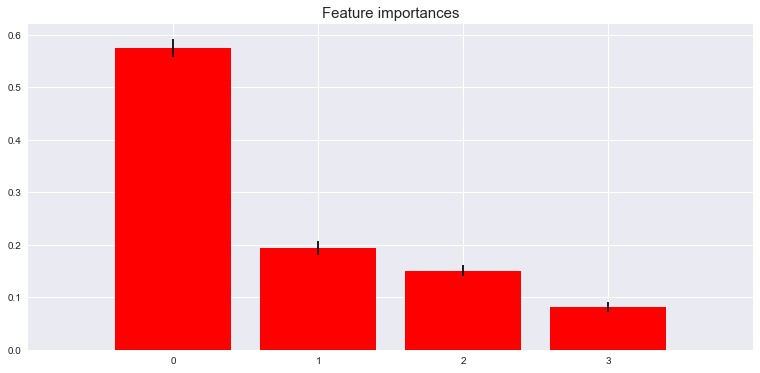

In [84]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [85]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.78      0.70      0.74     54775
          1       0.38      0.49      0.43     20956

avg / total       0.67      0.64      0.65     75731



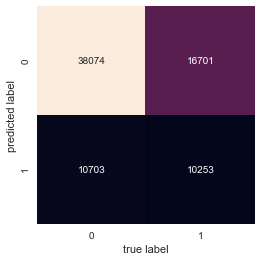

In [86]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [28]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.322412


# Random Forest Regressors
### Predicting number of backers using goal, days, launch month, launch year

In [87]:
from sklearn.ensemble import RandomForestRegressor
X_cols=['usd_goal_real', 'days', 'launch_month', 'launch_year']
X = kickstart[X_cols]
y = kickstart['backers']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)
forest = RandomForestRegressor(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.361485 	usd_goal_real
2. feature 2 	0.273499 	days
3. feature 1 	0.207376 	launch_month
4. feature 3 	0.157640 	launch_year


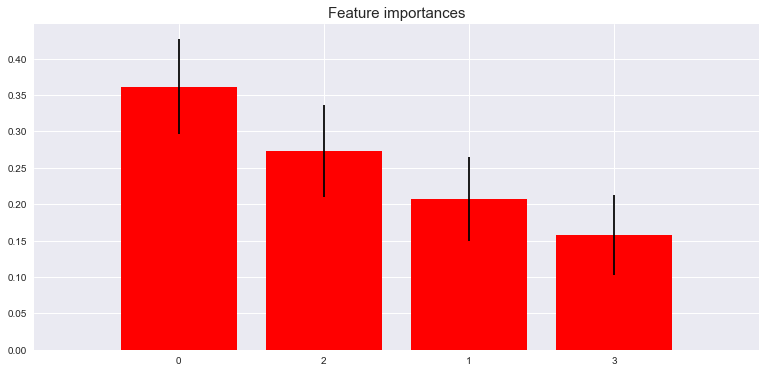

In [88]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))
    
# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [89]:
forest.score(Xtrain,ytrain)

0.5922829211071765

In [90]:
X_cols=['usd_goal_real', 'days', 'launch_month', 'launch_year']
X = kickstart[X_cols]
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.570218 	usd_goal_real
2. feature 1 	0.196580 	days
3. feature 2 	0.150820 	launch_month
4. feature 3 	0.082381 	launch_year


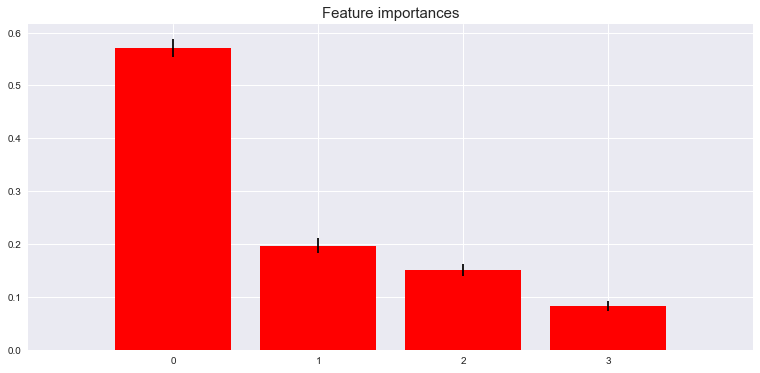

In [91]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))
    
# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [92]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.78      0.70      0.74     54747
          1       0.38      0.49      0.43     20984

avg / total       0.67      0.64      0.65     75731



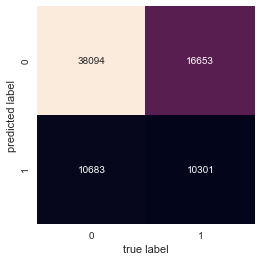

In [93]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [36]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.322486


In [94]:
y_prob = forest.predict_proba(Xtrain)

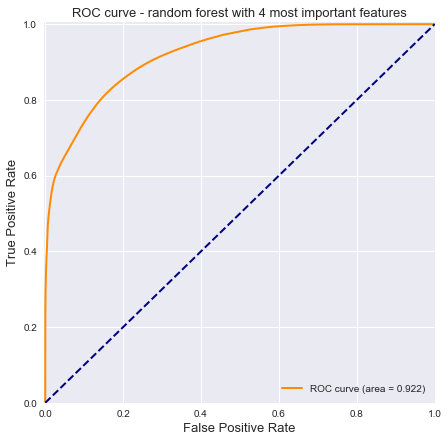

In [95]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1])
plt.ylim([0, 1.005])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 4 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

## Using backers as a predictor may be useful in monitoring the progress of a campaign as it progresses, helping campaigners make more informed decisions to market their campaign.

### The amount of days that has progressed could be a useful input variable as well, but the very limited amount of live campaigns in the dataset would not give us much predictive power.

In [96]:
X_cols=['backers','usd_goal_real','days', 'launch_month', 'launch_year']
X=kickstart[X_cols]
y=kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=y)

forest=RandomForestClassifier(n_estimators=100)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.659913 	backers
2. feature 1 	0.208944 	usd_goal_real
3. feature 2 	0.049701 	days
4. feature 3 	0.046590 	launch_month
5. feature 4 	0.034852 	launch_year


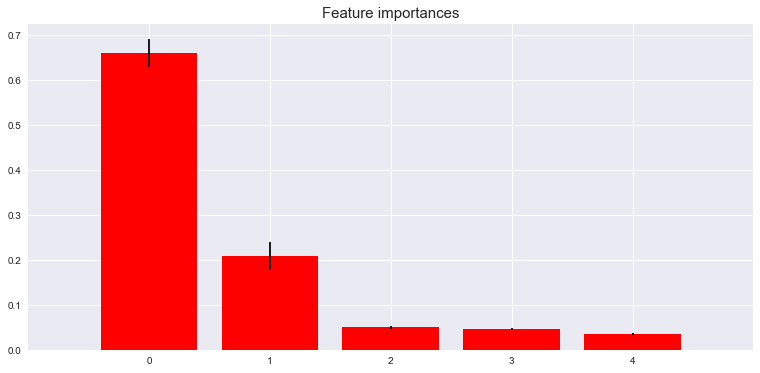

In [97]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1,
                                        indices[f],
                                        importances[indices[f]],
                                        X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [98]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.93      0.94      0.94     48318
          1       0.90      0.88      0.89     27413

avg / total       0.92      0.92      0.92     75731



In [42]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.714856


In [99]:
y_prob = forest.predict_proba(Xtrain)

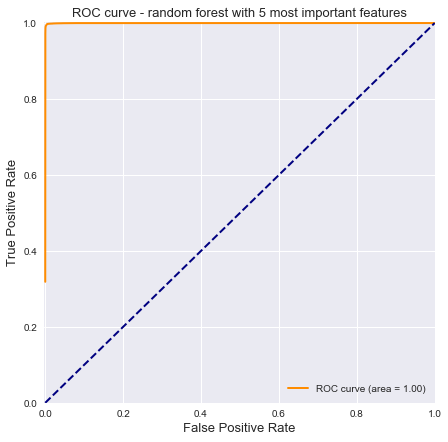

In [100]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 5 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

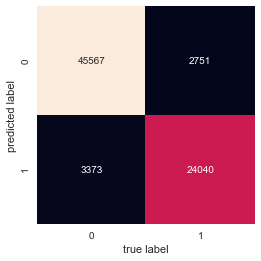

In [101]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [102]:
X_cols=['backers','usd_goal_real']
X=kickstart[X_cols]
y=kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=y)

forest=RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.752253 	backers
2. feature 1 	0.247747 	usd_goal_real


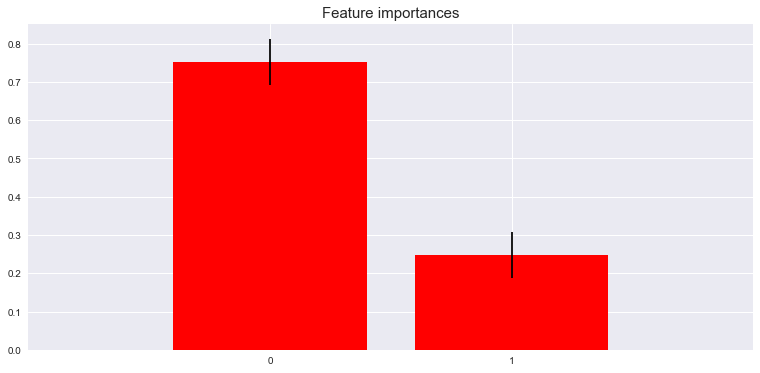

In [103]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1,
                                        indices[f],
                                        importances[indices[f]],
                                        X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [104]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.93      0.94      0.93     48342
          1       0.89      0.87      0.88     27389

avg / total       0.91      0.92      0.91     75731



In [60]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.914280


In [105]:
y_prob = forest.predict_proba(Xtrain)

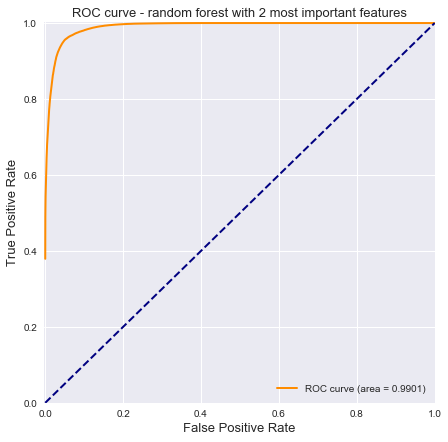

In [106]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 2 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

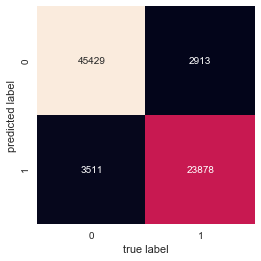

In [107]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Unsurprisingly, these models perform very well, as they essentially use an output variable that is closely related to the success as an input in order to predict the success.

### Since we are predicting a binary outcome, we will now see if a simpler, single variable input (one of the several most important features from the random forest) with logistic regression can be used to predict the success of a campaign.

### Our first model will use the usd_goal_real column as the predictor.

In [108]:
from sklearn.linear_model import LogisticRegression

X=kickstart.usd_goal_real.values.reshape(-1,1)
y=kickstart.successful.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)
logit = LogisticRegression()
logit.fit(X,y)

print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.646231
Accuracy of model which guesses failure everytime 0.646231


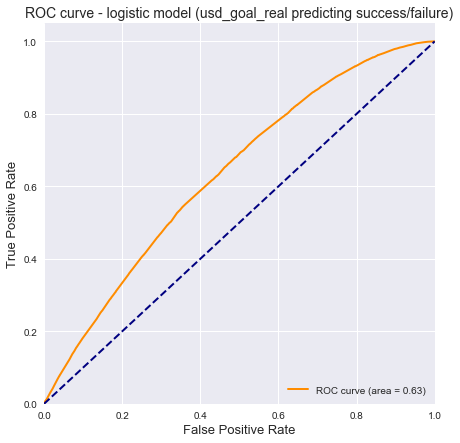

In [109]:
y_prob = logit.predict_proba(Xtrain)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - logistic model (usd_goal_real predicting success/failure)',fontsize=14)
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       1.00      0.64      0.78     75731
          1       0.00      0.00      0.00         0

avg / total       1.00      0.64      0.78     75731



/Users/chrisrutherford/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


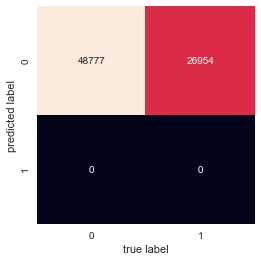

In [110]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evidently, this model won't be of much use at all, since it predicts failure every time. Hopefully a different predictor will be more accurate.

## Logistic Model - Predictor: Length of Campaign in Days

In [111]:
X = kickstart.days.values.reshape(-1,1)
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

logit.fit(Xtrain,ytrain)

print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime: %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.645684
Accuracy of model which guesses failure everytime: 0.646231


             precision    recall  f1-score   support

          0       1.00      0.64      0.78     75591
          1       0.00      0.41      0.00       140

avg / total       1.00      0.64      0.78     75731



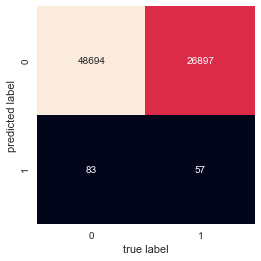

In [112]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### This model is not very useful either, likely due to complex relationship between the length of the campaign and the outcome, as seen in the graph of days vs. ratio.

In [113]:
X = kickstart.backers.values.reshape(-1,1)
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

logit.fit(Xtrain,ytrain)
print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime: %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.783219
Accuracy of model which guesses failure everytime: 0.646231


In [114]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.95      0.77      0.85     60709
          1       0.47      0.85      0.60     15022

avg / total       0.86      0.78      0.80     75731



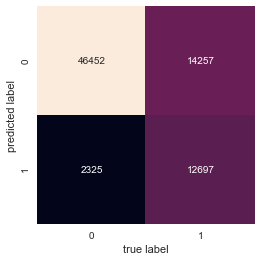

In [115]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [116]:
y_prob = logit.predict_proba(Xtrain)

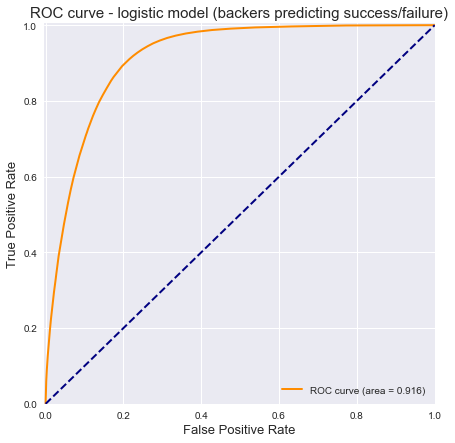

In [117]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.004, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - logistic model (backers predicting success/failure)',fontsize=15)
plt.legend(loc="lower right")
plt.show()

In [118]:
logit_score = cross_val_score(logit, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % logit_score.mean())

mean accuracy of 10-fold cv: 0.782593


## The complex relationships between the variables indicate that more complex models, like  random forests, are beneficial in making more accurate predictions.

### Main long-term goals: fine tuning parameters of random forests (classifiers and regressors), testing and fitting more models (especially making use of features that were generated but not used)
## -------------------------------------------------------------------
# Ideally, a separate model would be created for each year. The current model includes every year, which is not helpful in making a campaign successful - a campaign created in 2020 cannot be published in 2016.
## Future plans/analyses will amend this issue to address feature importance more accurately.